# Netatmo quality checks

In this notebook, we follow the methods of Napoly et al., (2018) [1] to perform quality checks on the Netatmo stations to control for common errors in citizen weather stations (CWS) data.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from uhi_drivers_lausanne import cws_qc

figwidth, figheight = plt.rcParams["figure.figsize"]

In [ ]:
netatmo_ts_df_filepath = "../data/interim/netatmo/ts-df.csv"
official_ts_df_filepath = "../data/interim/official-stations/ts-df.csv"
dst_filepath = "../data/interim/netatmo/ts-df-qc.csv"

In [ ]:
netatmo_ts_df = pd.read_csv(netatmo_ts_df_filepath, index_col="time", parse_dates=True)
# select temperature only and pivot to have stations as columns
netatmo_ts_df = (
    netatmo_ts_df[netatmo_ts_df["variable"] == "temperature"]
    .drop("variable", axis=1)
    .pivot(columns="id", values="value")
)
official_ts_df = pd.read_csv(
    official_ts_df_filepath, index_col="time", parse_dates=True
)

<Axes: xlabel='time', ylabel='T'>

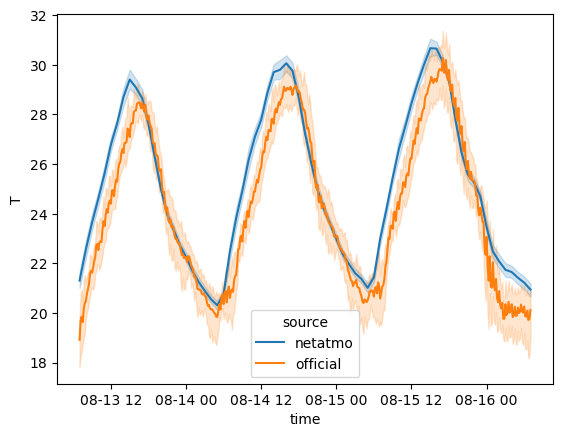

In [ ]:
cws_qc.comparison_lineplot(
    netatmo_ts_df,
    official_ts_df,
)


It seems that the Netatmo stations tend to be warmer than the official stations. As noted by Meier et al., (2017) [2], this is likely due to stations located in non-shaded areas, resulting in radiative errors.

In [ ]:
outlier_stations = cws_qc.get_outlier_stations(netatmo_ts_df)
outlier_stations.sum(), len(netatmo_ts_df.columns)

(40, 244)


It seems that 40 out of 244 Netatmo stations show a pattern that can be considered an outlier. We can filter them out and compare the CWS with the official stations again.

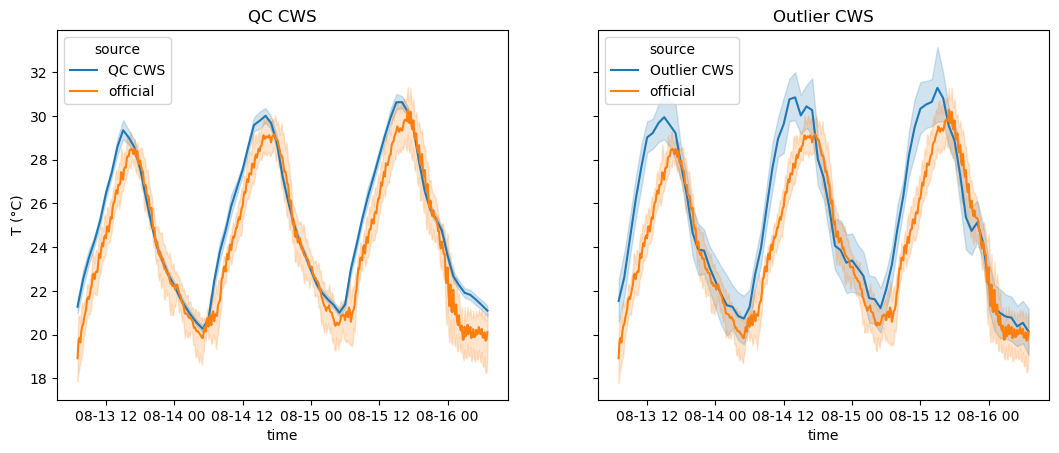

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(figwidth * 2, figheight), sharex=True, sharey=True
)
for cws_ts_df, label, ax in zip(
    [netatmo_ts_df.loc[:, ~outlier_stations], netatmo_ts_df.loc[:, outlier_stations]],
    ["QC CWS", "Outlier CWS"],
    axes,
):
    cws_qc.comparison_lineplot(
        cws_ts_df,
        official_ts_df,
        cws_label=label,
        ax=ax,
    )
    ax.set_title(label)
    ax.set_ylabel("T (°C)")


Once the outlier stations are filtered out, the CWS show a better agreement with the official stations, yet they still seem to be warmer. As suggested by Napoly et al., (2018) [1], another potential explanation is that some Netatmo stations are actually

In [ ]:
indoor_stations = cws_qc.get_indoor_stations(netatmo_ts_df)
indoor_stations.sum(), len(netatmo_ts_df.columns)

/home/martibosch/mambaforge/envs/uhi-drivers-lausanne/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/martibosch/mambaforge/envs/uhi-drivers-lausanne/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/martibosch/mambaforge/envs/uhi-drivers-lausanne/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


(49, 244)

It seems that 49 out of the 244 Netatmo stations show a pattern that corresponds to an indoor stations. We can again plot them separately:

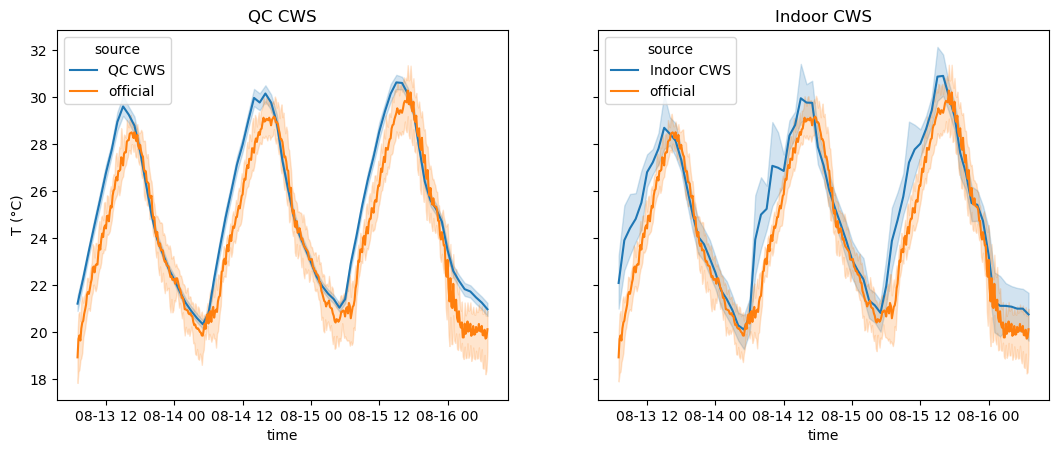

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(figwidth * 2, figheight), sharex=True, sharey=True
)
for cws_ts_df, label, ax in zip(
    [netatmo_ts_df.loc[:, ~indoor_stations], netatmo_ts_df.loc[:, indoor_stations]],
    ["QC CWS", "Indoor CWS"],
    axes,
):
    cws_qc.comparison_lineplot(
        cws_ts_df,
        official_ts_df,
        cws_label=label,
        ax=ax,
    )
    ax.set_title(label)
    ax.set_ylabel("T (°C)")

Unlike with the outlier stations, filtering out the indoor stations does not necessarily mean that the CWS show a better agreement with the official stations. We can try to filter out both the outlier and indoor stations:

In [ ]:
discard_stations = outlier_stations | indoor_stations
discard_stations.sum(), len(netatmo_ts_df.columns), (
    outlier_stations & indoor_stations
).sum()

(75, 244, 14)

A total of 75 stations are discarded, 14 of which are both outliers and indoor stations. We can plot the remaining stations:

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(figwidth * 2, figheight), sharex=True, sharey=True
)
for cws_ts_df, label, ax in zip(
    [netatmo_ts_df.loc[:, ~discard_stations], netatmo_ts_df.loc[:, discard_stations]],
    ["QC CWS", "Discarded CWS"],
    axes,
):
    cws_qc.comparison_lineplot(
        cws_ts_df,
        official_ts_df,
        cws_label=label,
        ax=ax,
    )
    ax.set_title(label)
    ax.set_ylabel("T (°C)")

Even when discarding the outlier and indoor stations, the CWS still seem to be warmer than the official stations. We can hypothesize that this is due to the fact that the CWS tend to be located in more urbanized environments. But confirming this constitutes a separate analysis to be conducted in a separate notebook.

Note that stations with misconfigured locations have already been descarded in the netatmo-processing notebook (since the procedure to discard them does not depend on the time-series of observations).

In [ ]:
# dump to a file
netatmo_ts_df.loc[:, ~discard_stations].to_csv(dst_filepath)

## References

1. Adrien Napoly, Tom Grassmann, Fred Meier, and Daniel Fenner. Development and application of a statistically-based quality control for crowdsourced air temperature data. *Frontiers in Earth Science*, pages 118, 2018.
2. Fred Meier, Daniel Fenner, Tom Grassmann, Marco Otto, and Dieter Scherer. Crowdsourcing air temperature from citizen weather stations for urban climate research. *Urban Climate*, 19:170–191, 2017.